In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
import glob
# directory reach
directory = os.path.abspath('')
append_path = os.path.dirname(directory) # go two folders up
from pykinect2 import PyKinectRuntime
from pykinect2 import PyKinectV2

kinectColor = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Color)
import pickle
# setting path
sys.path.append(append_path)
from cv2 import aruco
from datetime import timedelta

from support.pd_support import *
from support.calculations_support import *
from support.generate_ar_data import get_ar_pose_data, detect_ar_markers, add_time_col
from support.camera_calibration import *
from support.ar_calculations import *
from support.mecanum_calculations import *

In [67]:
_pth_calibration = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 20-07-22_10-53-15_690" #calib recording 0 : calibrated   
_pth_calibration = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_11-01-53_441" #calib recording 1 : calibrated
# _pth_calibration = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_11-37-01_726" #calib recording 2 : calibrated

# calibrate_camera(_pth_calibration)

In [68]:
""" importing calibration file """

calib_pth = os.path.join(_pth_calibration, "AR_CALIBRATION.msgpack")
_calib_file = open(calib_pth, "rb")
unpacker = mp.Unpacker(_calib_file, object_hook=mpn.decode)
_calib = []
for unpacked in unpacker:
    _calib.append(unpacked)

cameraMatrix = _calib[0][0]
distCoeffs = _calib[0][1]


yPos = 112
xPos = 274

yRes = 736
xRes = 864
scalling = 2
yRes

736

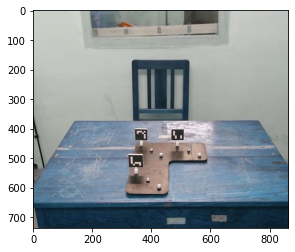

In [69]:
""" importing l frame data """
calib_file = open("new_l_frame4.pickle", "rb")
calib_img = pickle.load(calib_file)
calib_file.close()
plt.imshow(calib_img)

In [70]:
"""detect the aruco markers"""
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
arudo_parameters = aruco.DetectorParameters_create()

corners, ids, rejectedImgPoints = detect_ar_markers(calib_img, arudo_parameters, aruco_dict)

rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, cameraMatrix, distCoeffs)
rotation_vector

"""

Idx: 6 - zvector
Idx: 9 - orgin
Idx: 10 - xvector
"""

print(ids)
zvec = translation_vector[0][0]
zvec = np.reshape(zvec, (3, 1))
org = translation_vector[2][0] 
org = np.reshape(org, (3, 1))
xvec = translation_vector[1][0]
xvec = np.reshape(xvec, (3, 1))


translation_vector
zvec
rotMat = calculate_rotmat(xvec, zvec, org)
rotMat

t_xvec = zvec - org 

translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1) # adding the corrections in the new L frame

rotMat.T@t_xvec + translation_correction
rotMat.T@t_xvec 

[[ 6]
 [10]
 [ 9]]


array([[0.04363828],
       [0.        ],
       [0.20267824]])

In [72]:
# _data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 22-07-22_12-42-02_505" # session 5 test 1
# _data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 26-07-22_10-27-13_120" # session 6 test 0
# _data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 27-07-22_11-02-21_383" # session 7 test 0
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 28-07-22_16-11-46_370" # session 8 test 0
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 28-07-22_17-01-09_53" # test session without mocap
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 28-07-22_17-04-44_197" # test session without mocap
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_10-34-07_549" # session 9 test 0, with previous lframe :4
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_10-47-35_272" # session 9 test 1, with previous lframe :4
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_10-54-28_450" # session 9 test 2, with previous lframe :4
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_11-19-22_135" # session 9 test 3, with previous lframe :4
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_11-23-16_716" # session 9 test 4, with previous lframe :4
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 29-07-22_11-58-34_108" # session 9 test 5, with previous lframe :4

df = get_ar_pose_data(_data_pth, cameraMatrix, distCoeffs, process_raw=True)
df = add_time_col(df,  _data_pth)
df

returning dataframe


,frame_id,x,y,z,yaw,pitch,roll,time
0,5.0,-0.412717,-0.018922,1.276479,-2.079260,-2.013157,-0.413721,2022-07-29 11:59:19.438735
1,5.0,-0.412717,-0.018922,1.276479,-2.079260,-2.013157,-0.413721,2022-07-29 11:59:19.504956
2,5.0,-0.412717,-0.018922,1.276479,-2.079260,-2.013157,-0.413721,2022-07-29 11:59:19.571907
3,5.0,-0.413337,-0.018937,1.277384,-2.072358,-1.992768,-0.365906,2022-07-29 11:59:19.638580
4,5.0,-0.408525,-0.019031,1.263464,-2.061427,-2.009020,-0.367550,2022-07-29 11:59:19.704924
...,...,...,...,...,...,...,...,...
646,5.0,-0.051331,0.013112,1.217761,-2.051905,-2.019448,-0.427705,2022-07-29 12:00:04.167340
647,5.0,-0.050986,0.012963,1.202467,-2.027315,-1.984813,-0.425036,2022-07-29 12:00:04.233839
648,5.0,-0.051331,0.013112,1.217761,-2.051905,-2.019448,-0.427705,2022-07-29 12:00:04.299339
649,5.0,-0.051331,0.013112,1.217761,-2.051905,-2.019448,-0.427705,2022-07-29 12:00:04.365838


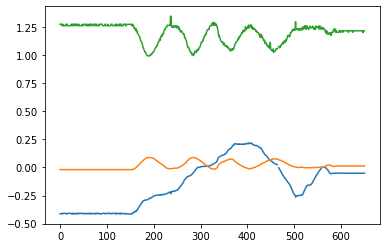

In [73]:
plt.plot(df["x"])
plt.plot(df["y"])
plt.plot(df["z"])

In [74]:

ar_df = pd.DataFrame(columns=["x", "y", "z"])

for i in range(len(df)):
    _val = df[["x", "y", "z"]].iloc[i]
    _val = np.reshape(_val.values, (3, 1))
    _val_t = _val - org
    _xyz = rotMat.T@_val_t + translation_correction
    _xyz = _xyz.reshape(3)
    ar_df.loc[i] = _xyz   
ar_df["time"]= df["time"]

In [75]:
ar_df["time"] = pd.to_datetime(ar_df["time"])

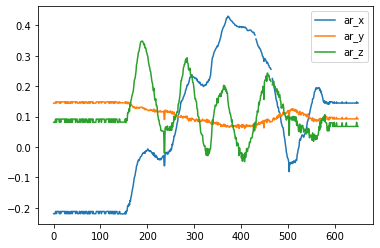

In [76]:
plt.plot(ar_df["x"], label="ar_x")
plt.plot(ar_df["y"], label="ar_y")
plt.plot(ar_df["z"], label="ar_z")
plt.legend()

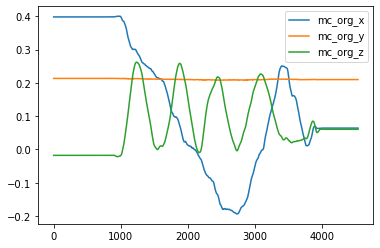

In [77]:
""" getting mc df"""
mc_df, mt_t = read_df_csv("ar_s9_t5.csv")

mc_df = add_datetime_col(mc_df, mt_t, "seconds")

"""get center point of the aruco marker"""

_tr = mc_df[["top_right_x", "top_right_y", "top_right_z"]]
_tl = mc_df[["top_left_x", "top_left_y", "top_left_z"]]
_br = mc_df[["bot_right_x", "bot_right_y", "bot_right_z"]]
_bl = mc_df[["bot_left_x", "bot_left_y", "bot_left_z"]]


# center point
_ctr_x = (_tr["top_right_x"] + _tl["top_left_x"] + _br["bot_right_x"] + _bl["bot_left_x"])/4
_ctr_y = (_tr["top_right_y"] + _tl["top_left_y"] + _br["bot_right_y"] + _bl["bot_left_y"])/4
_ctr_z = (_tr["top_right_z"] + _tl["top_left_z"] + _br["bot_right_z"] + _bl["bot_left_z"])/4


plt.plot(_ctr_x, label="mc_org_x")
plt.plot(_ctr_y, label="mc_org_y")
plt.plot(_ctr_z, label="mc_org_z")
plt.legend()

# mc_df
# _ctr_x
# mc_df
# _tr

-0.09864816964036077


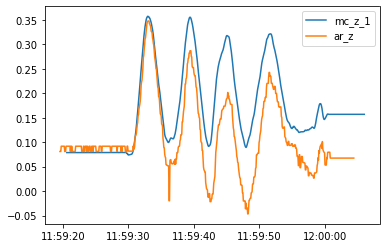

In [95]:
diff = _ctr_z[0]-ar_df["z"][0]

plt.plot(mc_df["time"], mc_df["bot_right_z"]-diff, label="mc_z")
plt.plot(ar_df["time"], ar_df["z"].interpolate().rolling(3).median(), label="ar_z")
plt.legend()
print(diff)

0.35726953007636375


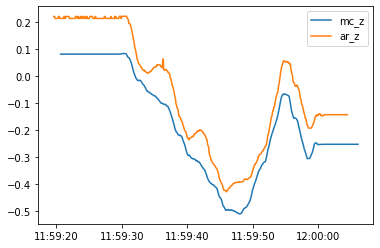

In [89]:
# diff = _ctr_x[0]-ar_df["x"][0]*-1

plt.plot(mc_df["time"], mc_df["top_right_x"]-diff, label="mc_z")
plt.plot(ar_df["time"], -1*ar_df["x"].interpolate().rolling(3).median(), label="ar_z")
plt.legend()
print(diff)

0.35726953007636375


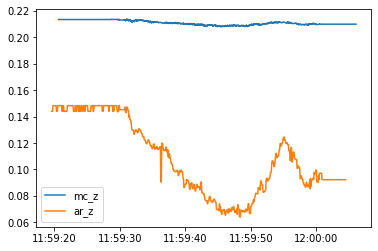

In [88]:
diff = _ctr_y[0]-ar_df["y"][0]*-1

plt.plot(mc_df["time"], _ctr_y, label="mc_z")
plt.plot(ar_df["time"], ar_df["y"].interpolate().rolling(3).median(), label="ar_z")
plt.legend()
print(diff)

In [95]:
"""reading wheels data"""
_csv_pth = os.path.join(_data_pth, "imu01.csv")
cart_df = pd.read_csv(_csv_pth)

cart_df = add_datetime_diff(cart_df, mt_t, "sync", "mils", False)
cart_df

imu_df = cart_df[["sync", "mils", "ax", "ay", "az", "gx", "gy", "gz", "time"]]

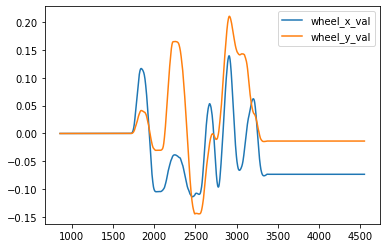

In [96]:
""" this calculates the robots position using mecanum wheels"""

radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000



cart_df = set_zero(cart_df, column_name=["e_fr", "e_fl", "e_rr", "e_rl"])
cart_df, c_names = get_angular_velocity(cart_df, column_name=["e_fr", "e_fl", "e_rr", "e_rl"])
cart_df, c_names = get_directional_velocity(cart_df, c_names, radius, lx, ly)
cart_df, c_names = get_position(cart_df)

plt.plot(cart_df["x_val"], label="wheel_x_val")
plt.plot(cart_df["y_val"], label="wheel_y_val")
plt.legend()


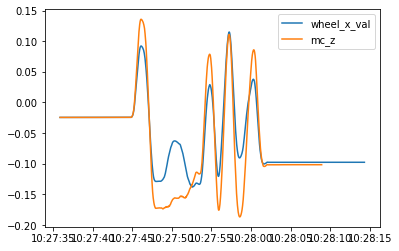

In [106]:
plt.plot(cart_df["time"], cart_df["x_val"]-(cart_df["x_val"].iloc[0] - mc_df["org_z"].iloc[0]), label="wheel_x_val")
plt.plot(mc_df["time"], mc_df["org_z"], label="mc_z")
# plt.plot(ar_df["time"] - timedelta(seconds=8.4), ar_df["z"].interpolate().rolling(3).median()-0.2, label="ar_z") #filtered data
plt.legend()

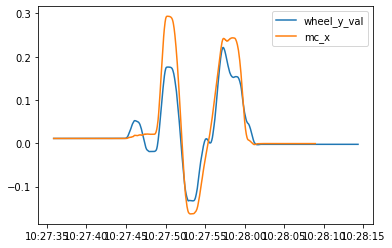

In [104]:
plt.plot(cart_df["time"], cart_df["y_val"]-(cart_df["y_val"].iloc[0] - mc_df["org_x"].iloc[0]), label="wheel_y_val")
plt.plot(mc_df["time"], mc_df["org_x"], label="mc_x")
# plt.plot(ar_df["time"] - timedelta(seconds=8.4), (ar_df["x"].interpolate().rolling(3).median()-0.16)*-1, label="ar_x") #filtered data
plt.legend()

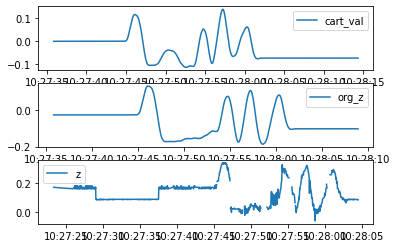

In [99]:
plt.subplot(3, 1, 1)
plt.plot(cart_df["time"],  cart_df["x_val"], label="cart_val")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(mc_df["time"],  mc_df["org_z"], label="org_z")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(ar_df["time"]- timedelta(seconds=8.2),  ar_df["z"], label="z")
plt.legend()

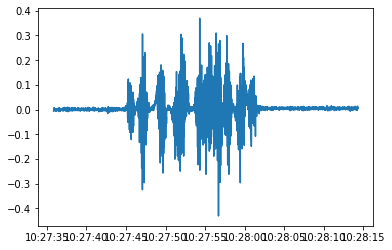

In [100]:
plt.plot(imu_df["time"], imu_df["ax"], label="ax")